In [13]:
import regex as re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import difflib
import random
import contractions
from tabulate import tabulate
from pprint import pprint
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from functions import preprocess
from itertools import combinations
from IPython.display import Markdown as md
from nltk.metrics.agreement import AnnotationTask
from sklearn.neural_network import MLPClassifier
from statsmodels.stats import inter_rater as irr
import krippendorff as kd
!mkdir -p figures

random.seed(10) # Don't change this!

Opening and reading all the files.

In [14]:
# Tokenisation pattern 
with open("pattern.txt", "r") as f:
    pat = re.compile(f.read())
    
# Irony 
with open("tweeteval/datasets/irony/train_text.txt", "r") as f:
    irony = f.read()

# Multiclass stance 
with open("tweeteval/datasets/stance/climate/train_text.txt", "r") as f:
    stance_climate = f.read()

with open("tweeteval/datasets/stance/hillary/train_text.txt", "r") as f:
    stance_hillary = f.read()

with open("tweeteval/datasets/stance/feminist/train_text.txt", "r") as f:
    stance_feminist = f.read()

with open("tweeteval/datasets/stance/abortion/train_text.txt", "r") as f:
    stance_abortion = f.read()

with open("tweeteval/datasets/stance/atheism/train_text.txt", "r") as f:
    stance_atheism = f.read()

#text_file = "tweeteval/datasets/stance/abortion/train_text.txt"

#with open(text_file, "r") as f:
    #text = convert_links(f.read().lower())

Tokenise all datasets

In [15]:
def tokenize(pat, text):
    # Function to tokenize text 
    return re.findall(pat, text) 

In [16]:
irony_corpus = tokenize(pat, irony)

climate_corpus = tokenize(pat, stance_climate)

hillary_corpus = tokenize(pat, stance_hillary)

feminist_corpus = tokenize(pat, stance_feminist)

abortion_corpus = tokenize(pat, stance_abortion)

atheism_corpus = tokenize(pat, stance_atheism)

Functions: Normalisation and statistics.

In [17]:
def statistics(corpus):
    counts = Counter(corpus)
    corpus_size = len(corpus)
    vocab_size = len(counts)
    return (counts, corpus_size, vocab_size, vocab_size/corpus_size)

def zipf(corpus):
    voc = Counter(corpus)
    frq = pd.DataFrame(voc.most_common(), columns=['token', 'frequency'])

    # Index in the sorted list
    frq['idx'] = frq.index + 1

    # Frequency normalised by corpus size
    frq['norm_freq'] = frq.frequency / len(corpus)

    # Cumulative normalised frequency
    frq['cumul_frq'] = frq.norm_freq.cumsum()

    sns.set_theme(style='whitegrid')

    # Plot: Cumulative frequency by index
    sns.relplot(x='idx', y='cumul_frq', data=frq)
    plt.show()

    # Plot: Cumulative frequency by index, top 10000 tokens
    sns.relplot(x='idx', y='cumul_frq', data=frq[:10000], kind='line')
    plt.show()

    # Plot: Log-log plot for Zipf's law
    frq['log_frq'] = np.log(frq.frequency)
    frq['log_rank'] = np.log(frq.frequency.rank(ascending=False))
    sns.relplot(x='log_rank', y='log_frq', data=frq)
    plt.show()


# 2 Characterising your data

Calculating label ratio and add it to a dataframe

In [18]:
paths = []
base_path = "tweeteval/datasets/"
files = ["train_labels.txt", "val_labels.txt", "test_labels.txt"]
paths.extend([base_path + f"irony/{file}" for file in files])
for stance in ["abortion", "atheism", "climate", "feminist", "hillary"]:
    paths.extend([base_path + f"stance/{stance}/{file}" for file in files])
label_dict = {}
for path in paths:
    labels = np.loadtxt(path, dtype=int)
    col_name = path[path.rfind("/", 0, path.rfind("/") - 1) + 1: path.rfind("_")].replace("/", "_")
    label_dict[col_name] = labels

In [19]:
# Virker ikke.
"""
table = {"headers": [""], "labels": {0: ["0"], 1: ["1"], 2: ["2"]}}

table["headers"].append(dataset)
for i in uniq:
    table["labels"][i].append(count[i]/np.sum(count))
if 2 not in uniq:
    table["labels"][2].append("")

table = tabulate(list(table["labels"].values(), headers=table["headers"]))

"""

'\ntable = {"headers": [""], "labels": {0: ["0"], 1: ["1"], 2: ["2"]}}\n\ntable["headers"].append(dataset)\nfor i in uniq:\n    table["labels"][i].append(count[i]/np.sum(count))\nif 2 not in uniq:\n    table["labels"][2].append("")\n\ntable = tabulate(list(table["labels"].values(), headers=table["headers"]))\n\n'

In [20]:
def label_ratio_binary(labels):
    return print(f" Irony: {sum(labels)/len(labels)} \n Not irony: {1-sum(labels)/len(labels)}")

def label_ratio_multi(d):
    table = {"headers": ["0", "1", "2"], "rows": {}}
    for dataset,labels in d.items():
        uniq, counts = np.unique(labels,return_counts=True)
        table["rows"][dataset] = [dataset]
        for i in uniq:
            table["rows"][dataset].append(counts[i]/np.sum(counts))
        if 2 not in uniq:
            table["rows"][dataset].append(None)
        # if len(uniq)==2:
        #     print(f" Irony({dataset})  {counts[1]/np.sum(counts)} \n Not irony({dataset}): {counts[0]/np.sum(counts)}")
        # if len(uniq)==3:
        #     print(f" Neutral({dataset}): {counts[0]/np.sum(counts)} \n Against({dataset}): {counts[1]/np.sum(counts)} \n In favor({dataset}): {counts[2]/np.sum(counts)}")
    return table

table = label_ratio_multi(label_dict)
table = tabulate(list(table["rows"].values()), headers=table["headers"], tablefmt="github", floatfmt=".3f")
md(table)

|                |     0 |     1 |     2 |
|----------------|-------|-------|-------|
| irony_train    | 0.495 | 0.505 |       |
| irony_val      | 0.523 | 0.477 |       |
| irony_test     | 0.603 | 0.397 |       |
| abortion_train | 0.271 | 0.543 | 0.186 |
| abortion_val   | 0.273 | 0.545 | 0.182 |
| abortion_test  | 0.161 | 0.675 | 0.164 |
| atheism_train  | 0.228 | 0.592 | 0.180 |
| atheism_val    | 0.231 | 0.596 | 0.173 |
| atheism_test   | 0.127 | 0.727 | 0.145 |
| climate_train  | 0.425 | 0.037 | 0.538 |
| climate_val    | 0.425 | 0.050 | 0.525 |
| climate_test   | 0.207 | 0.065 | 0.728 |
| feminist_train | 0.189 | 0.494 | 0.317 |
| feminist_val   | 0.194 | 0.493 | 0.313 |
| feminist_test  | 0.154 | 0.642 | 0.204 |
| hillary_train  | 0.258 | 0.571 | 0.171 |
| hillary_val    | 0.261 | 0.565 | 0.174 |
| hillary_test   | 0.264 | 0.583 | 0.153 |

In [21]:
def label_ratio_multi(d):
    table = {"headers": ["label"], "rows": {0: ["0"], 1: ["1"], 2: ["2"]}}
    for dataset,labels in d.items():
        uniq, counts = np.unique(labels, return_counts=True)
        table["headers"].append(dataset)
        for i in uniq:
            table["rows"][i].append(counts[i]/np.sum(counts))
        if 2 not in uniq:
            table["rows"][2].append(None)
    return table

table = label_ratio_multi(label_dict)
table = tabulate(list(table["rows"].values()), headers=table["headers"], tablefmt="latex_booktabs", floatfmt=".3f")
print(table)

\begin{tabular}{rrrrrrrrrrrrrrrrrrr}
\toprule
   label &   irony\_train &   irony\_val &   irony\_test &   abortion\_train &   abortion\_val &   abortion\_test &   atheism\_train &   atheism\_val &   atheism\_test &   climate\_train &   climate\_val &   climate\_test &   feminist\_train &   feminist\_val &   feminist\_test &   hillary\_train &   hillary\_val &   hillary\_test \\
\midrule
       0 &         0.495 &       0.523 &        0.603 &            0.271 &          0.273 &           0.161 &           0.228 &         0.231 &          0.127 &           0.425 &         0.425 &          0.207 &            0.189 &          0.194 &           0.154 &           0.258 &         0.261 &          0.264 \\
       1 &         0.505 &       0.477 &        0.397 &            0.543 &          0.545 &           0.675 &           0.592 &         0.596 &          0.727 &           0.037 &         0.050 &          0.065 &            0.494 &          0.493 &           0.642 &           0.571 &        

Statistical properties of our corpora.

Creating a function that returns a data frame with the different tokens, their frequency, normalised and cumulative frequency

In [22]:
def datfr(corpus):
    voc = Counter(corpus)
    frq = pd.DataFrame(voc.most_common(), columns=['token', 'frequency'])

    # Index in the sorted list
    frq['idx'] = frq.index + 1

    # Frequency normalised by corpus size
    frq['norm_freq'] = frq.frequency / len(corpus)

    # Cumulative normalised frequency
    frq['cumul_frq'] = frq.norm_freq.cumsum()
    sns.set_theme(style='whitegrid')
    return(frq)

In [23]:
#%%script echo skipping
# calculating corpora statistics, including corpus size, vocabulary size and type/token ratio

#Skipping because it takes a long time and a lot of plots

datasets = ["abortion", "atheism", "climate", "feminist", "hillary", "irony"]
stance_texts = []
for stance in datasets[:-1]:
    with open(f"tweeteval/datasets/stance/{stance}/test_text.txt") as f:
        stance_texts.append(f.read())

stance_texts.append(irony)

for text, stance in zip(stance_texts, datasets):
    print(stance.title())
    corpus = tokenize(pat, text)
    stats = statistics(corpus)
    print(f"Corpus size: {stats[1]}\Vocabulary size: {stats[2]}\tType/token ratio: {stats[3]:.3}\n")
    #print(datfr(corpus).head(10))


Abortion
Corpus size: 4714\Vocabulary size: 1727	Type/token ratio: 0.366

Atheism
Corpus size: 3816\Vocabulary size: 1578	Type/token ratio: 0.414

Climate
Corpus size: 2763\Vocabulary size: 1290	Type/token ratio: 0.467

Feminist
Corpus size: 4945\Vocabulary size: 1832	Type/token ratio: 0.37

Hillary
Corpus size: 4822\Vocabulary size: 1793	Type/token ratio: 0.372

Irony
Corpus size: 38944\Vocabulary size: 10168	Type/token ratio: 0.261



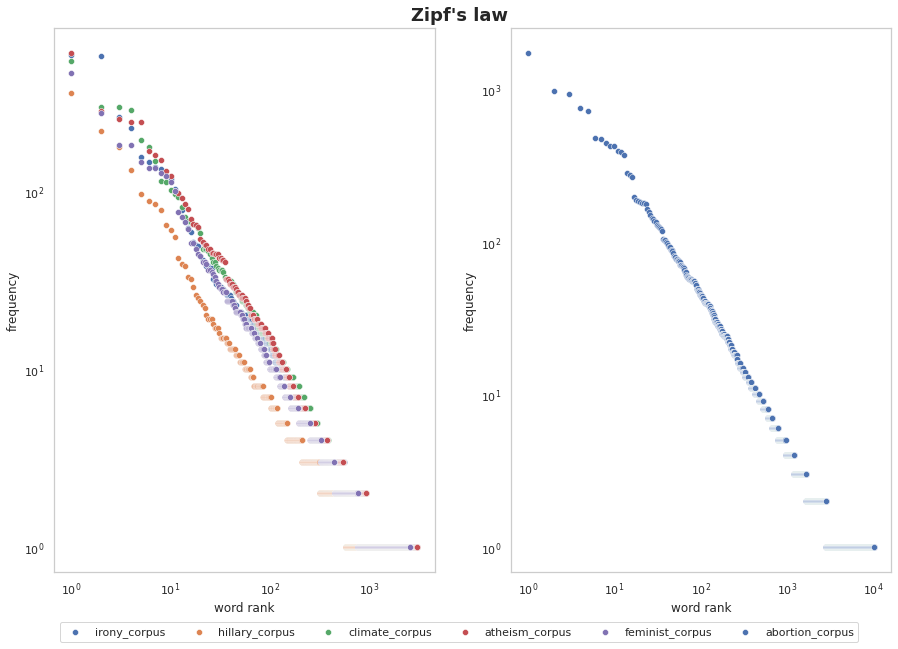

In [56]:
tokenised_datasets = [irony_corpus, hillary_corpus, climate_corpus, atheism_corpus, feminist_corpus, abortion_corpus]

color_dict = ['brown',
                  'green',
                  'orange',
                  'red',
                   'dodgerblue',
                   "yellow"]

names = ["irony_corpus","hillary_corpus", "climate_corpus", "atheism_corpus", "feminist_corpus", "abortion_corpus"]

irony_df = datfr(irony_corpus)
hillary_df = datfr(hillary_corpus)
climate_df = datfr(climate_corpus)
abortion_df = datfr(abortion_corpus)
feminist_df = datfr(feminist_corpus)
atheism_df = datfr(atheism_corpus)

all_dfs = [irony_df, hillary_df, climate_df, abortion_df, feminist_df, atheism_df]
fig,axs = plt.subplots(1,2,figsize=(15,10))

c = 0
for df in all_dfs:
    if c == 0:
        sns.scatterplot(x='idx', y='frequency', data=df, ax = axs[1])
        c += 1
    else:
        sns.scatterplot(x='idx', y='frequency', data=df, ax = axs[0])
for ax in axs:
    ax.set(xscale="log", yscale="log")
    ax.grid(False)
    ax.set_xlabel("word rank")
fig.suptitle("Zipf's law", fontweight="bold", fontsize=18, x=0.5,y=0.91)
fig.legend(labels=names, loc = "lower center", bbox_to_anchor=(0.5,0.02), ncol=6)
plt.savefig("figures/zipf_law.png", dpi=400, bbox_inches="tight")

In [57]:
x = irony_df["idx"]
y = irony_df["frequency"]

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(y,x);

print(slope, intercept)
irony_df

-16.3229453840502 5147.017779802955


,token,frequency,idx,norm_freq,cumul_frq
0,@user,1735,1,0.044551,0.044551
1,the,968,2,0.024856,0.069407
2,to,931,3,0.023906,0.093313
3,a,756,4,0.019412,0.112726
4,I,724,5,0.018591,0.131317
...,...,...,...,...,...
10163,#skincare,1,10164,0.000026,0.999897
10164,🛀,1,10165,0.000026,0.999923
10165,union,1,10166,0.000026,0.999949
10166,shorted,1,10167,0.000026,0.999974


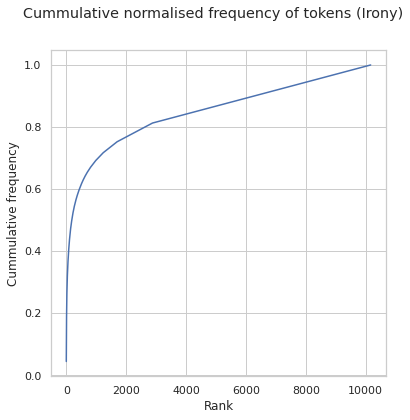

In [61]:
y = (irony_df["cumul_frq"])
x = (irony_df["idx"])
plt.figure(figsize=(6, 6))
plt.plot(x,y)
plt.axes
plt.xlabel('Rank')
plt.ylabel('Cummulative frequency')
plt.suptitle('Cummulative normalised frequency of tokens (Irony)')
plt.savefig('figures/cumul_dist_irony.png')

## 3 Manual Annotation and Inter-Annotator Agreement

In [ ]:
#random.seed(10)

lines = []
with open("tweeteval/datasets/irony/train_text.txt") as f:
    for line in f:
        lines.append(line.strip())

random_lines_index = sorted(random.sample([i for i in range(0, len(lines))], k = 100))

true_vals = []
with open("tweeteval/datasets/irony/train_labels.txt") as f:
    for line in f:
        true_vals.append(int(line.strip()))

validation = []
for i in random_lines_index:
    validation.append(true_vals[i])

with open("manual_annotation.txt", "w") as f:
    for i in range(100):
        f.write(f"{random_lines_index[i]}@@@ {lines[random_lines_index[i]]}")
        f.write("\n")

$$
    \underbrace{\stackrel{1}{\text{in}}\quad\stackrel{2}{\text{the}}}_{\stackrel{\text{bigram}}{\text{2-gram}}}
    \qquad p(\text{the} \;|\; \underbrace{\phantom{text}\text{in}\phantom{text}}_{\text{firstorder MM}})
$$

In [ ]:
df = pd.read_csv("manual_annotations/annotation_results.csv")
df = df.drop(["Unnamed: 0"], axis = 1)
df["Gold"] = validation

In [ ]:
tuple_list = []
for name in list(df)[1:]:
    tuples = list(zip([name] * len(df["idx"]), df["idx"], df[name]))
    tuple_list.extend(tuples)

manual = AnnotationTask(data=tuple_list)

In [ ]:
statsmodels_df = df.drop(["idx"], axis = 1)
print("fleiss_alpha",irr.fleiss_kappa(irr.aggregate_raters(statsmodels_df)[0], method = "fleiss"))

statsmodels_trans_df = statsmodels_df.transpose()
print("krippendorff",kd.alpha(statsmodels_trans_df, level_of_measurement='nominal'))

fleiss_alpha 0.4612794612794613
krippendorff 0.46217732884399554


In [ ]:
statsmodels_gold_df = statsmodels_df.copy()
statsmodels_gold_df["validation"] = validation
print("fleiss_alpha",irr.fleiss_kappa(irr.aggregate_raters(statsmodels_gold_df)[0], method = "fleiss"))

statsmodels_gold_trans_df = statsmodels_gold_df.transpose()
print("krippendorff",kd.alpha(statsmodels_gold_trans_df, level_of_measurement='nominal'))

fleiss_alpha 0.48623571811977573
krippendorff 0.48696966709389067


In [ ]:
names = ["Marie", "Frida", "Magnus", "Viggo", "Gustav"]

tuple_list = []
for name in list(df)[1:]:
    tuples = list(zip([name] * len(df["idx"]), df["idx"], df[name]))
    tuple_list.extend(tuples)

manual_gold = AnnotationTask(data=tuple_list)

In [ ]:
df = pd.read_csv("manual_annotations/annotation_results.csv")
df = df.drop(["Unnamed: 0"], axis = 1)
df["Gold"] = validation
names = ["Marie", "Frida", "Magnus", "Viggo", "Gustav"]

tuple_list = []
for name in list(df)[1:]:
    tuples = list(zip([name] * len(df["idx"]), df["idx"], df[name]))
    tuple_list.extend(tuples)

manual_gold = AnnotationTask(data=tuple_list)

combs = list(map(lambda x: (x[0], x[1], manual_gold.kappa_pairwise(*x)), combinations(names, 2)))
combs.extend(map(lambda x: (x[0], x[1], manual_gold.kappa_pairwise(*x)), zip(names, ["Gold"] * len(names))))
table = tabulate(combs, headers=["Annotator 1", "Annotator 2", "Kappa Pairwise"], tablefmt="latex_booktabs", floatfmt=".3f")
print(table)
print(f"\n###  Average Agreement with Gold: {np.mean(list(map(lambda x: x[2], combs[-5:]))):.3f}")

\begin{tabular}{llr}
\toprule
 Annotator 1   & Annotator 2   &   Kappa Pairwise \\
\midrule
 Marie         & Frida         &            0.376 \\
 Marie         & Magnus        &            0.408 \\
 Marie         & Viggo         &            0.362 \\
 Marie         & Gustav        &            0.333 \\
 Frida         & Magnus        &            0.601 \\
 Frida         & Viggo         &            0.606 \\
 Frida         & Gustav        &            0.470 \\
 Magnus        & Viggo         &            0.615 \\
 Magnus        & Gustav        &            0.440 \\
 Viggo         & Gustav        &            0.486 \\
 Marie         & Gold          &            0.517 \\
 Frida         & Gold          &            0.364 \\
 Magnus        & Gold          &            0.545 \\
 Viggo         & Gold          &            0.465 \\
 Gustav        & Gold          &            0.403 \\
\bottomrule
\end{tabular}

###  Average Agreement with Gold: 0.459


In [ ]:
print(tabulate(combs, headers=["Annotator 1", "Annotator 2", "Kappa Pairwise"], tablefmt="html", floatfmt=".3f"))

<table>
<thead>
<tr><th>Annotator 1  </th><th>Annotator 2  </th><th style="text-align: right;">  Kappa Pairwise</th></tr>
</thead>
<tbody>
<tr><td>Marie        </td><td>Frida        </td><td style="text-align: right;">           0.376</td></tr>
<tr><td>Marie        </td><td>Magnus       </td><td style="text-align: right;">           0.408</td></tr>
<tr><td>Marie        </td><td>Viggo        </td><td style="text-align: right;">           0.362</td></tr>
<tr><td>Marie        </td><td>Gustav       </td><td style="text-align: right;">           0.333</td></tr>
<tr><td>Frida        </td><td>Magnus       </td><td style="text-align: right;">           0.601</td></tr>
<tr><td>Frida        </td><td>Viggo        </td><td style="text-align: right;">           0.606</td></tr>
<tr><td>Frida        </td><td>Gustav       </td><td style="text-align: right;">           0.470</td></tr>
<tr><td>Magnus       </td><td>Viggo        </td><td style="text-align: right;">           0.615</td></tr>
<tr><td>Magnu

In [ ]:
for i in range(100):
    if sum(df.iloc[i,1:]) == 3:
        tweetnumber = random_lines_index[i]
        print("idx:",tweetnumber)
        print(f'Tweet: {lines[tweetnumber]}\nLabels: \n{df.iloc[i,1:]} \n')

idx: 266
Tweet: @user ha yeah which is your opinion, which like mine, means nothing ;) they're in.
Labels: 
Marie     1
Frida     1
Magnus    0
Gustav    0
Viggo     1
Gold      0
Name: 8, dtype: int64 

idx: 782
Tweet: oh lord!  RT @user RT @user Before becoming an actor, Tom Cruise wanted to be a Catholic priest.
Labels: 
Marie     1
Frida     0
Magnus    0
Gustav    0
Viggo     1
Gold      1
Name: 26, dtype: int64 

idx: 844
Tweet: @user (281): If I had feelings, you would have hurt them.
Labels: 
Marie     0
Frida     1
Magnus    1
Gustav    0
Viggo     0
Gold      1
Name: 28, dtype: int64 

idx: 980
Tweet: Carbon everywhere :) #carbon #hood  #sticker #strips #down #red #automotive #dope #cars...
Labels: 
Marie     1
Frida     1
Magnus    0
Gustav    1
Viggo     0
Gold      0
Name: 32, dtype: int64 

idx: 1093
Tweet: #notcies #eu Juncker receives birthday surprise: One million signatures opposing TTIP and CETA
Labels: 
Marie     1
Frida     1
Magnus    0
Gustav    1
Viggo     0
Gol

# 4 Automatic Prediction

### Normalisation of all our corpora

In [ ]:
train_labels = "/work/fyp2022g03GroupB2/tweeteval/datasets/irony/train_labels.txt"
irony_tweets_path = "/work/fyp2022g03GroupB2/tweeteval/datasets/irony/train_text.txt"
Y = np.loadtxt(train_labels)

In [ ]:
def test_classifier(classifier, pattern, text_train, labels_train, text_val, labels_val):
    clf = make_pipeline(CountVectorizer(token_pattern=pat, strip_accents="unicode", ngram_range=(2,2)),
                        TfidfTransformer(), classifier)
    clf.fit(preprocess(text_train), labels_train)
    pred = clf.predict(preprocess(text_val))
    print(metrics.classification_report(labels_val, pred, digits=3))
    return metrics.classification_report(labels_val, pred, digits=3, output_dict=True, labels=[0, 1])

In [ ]:
with open("tweeteval/datasets/irony/val_text.txt", "r") as f:
    irony_val = f.read().rstrip()
val_labels = np.loadtxt("tweeteval/datasets/irony/val_labels.txt")
pred_labels = clf.predict(preprocess(irony_val))
np.mean(pred_labels == val_labels)

NameError: name 'clf' is not defined

In [ ]:
text = preprocess(irony)

clf2 = train(MLPClassifier(solver='adam', learning_rate='adaptive', activation='tanh'))
pred_labels2 = clf2.predict(preprocess(irony_val))
np.mean(pred_labels2 == val_labels)

NameError: name 'train' is not defined

In [ ]:
len(CountVectorizer(token_pattern=pat, strip_accents="unicode").fit(preprocess(irony_train)).vocabulary_)

8848

In [ ]:
clf3 = train(MultinomialNB())

pred_labels3 = clf3.predict(preprocess(irony_val))
np.mean(pred_labels3 == val_labels)

0.6418848167539267

In [ ]:
with open("tweeteval/datasets/irony/train_text.txt", "r") as f:
    irony_train_text = f.read().rstrip()
irony_train_labels = np.loadtxt("tweeteval/datasets/irony/train_labels.txt")
with open("tweeteval/datasets/irony/val_text.txt", "r") as f:
    irony_val_text = f.read().rstrip()
irony_val_labels = np.loadtxt("tweeteval/datasets/irony/val_labels.txt")
with open("pattern.txt", "r") as f:
    pattern = f.read().rstrip()
classifier = SGDClassifier(max_iter=5000, tol=1e-4)
tc = test_classifier(classifier, pattern, irony_train_text, irony_train_labels, irony_val_text, irony_val_labels)

TypeError: first argument must be string or compiled pattern

In [ ]:
content = [tuple([k] + [tc[k][val] for val in ["precision", "recall", "f1-score", "support"]]) for k in ("0", "1", "macro avg", "weighted avg")]
content.insert(2, ())
content.insert(3, ("accuracy", None, None, tc["accuracy"], None))
table = tabulate(content, headers=["", "Precision", "Recall", "F1-score", "support"], tablefmt="github", floatfmt=".3f")
md(table)

|              |   Precision |   Recall |   F1-score |   support |
|--------------|-------------|----------|------------|-----------|
| 0            |       0.649 |    0.623 |      0.636 |       499 |
| 1            |       0.605 |    0.632 |      0.618 |       456 |
|              |             |          |            |           |
| accuracy     |             |          |      0.627 |           |
| macro avg    |       0.627 |    0.627 |      0.627 |       955 |
| weighted avg |       0.628 |    0.627 |      0.627 |       955 |

In [ ]:
tc

{'0': {'precision': 0.6492693110647182,
  'recall': 0.6232464929859719,
  'f1-score': 0.6359918200408998,
  'support': 499},
 '1': {'precision': 0.6050420168067226,
  'recall': 0.631578947368421,
  'f1-score': 0.6180257510729613,
  'support': 456},
 'accuracy': 0.6272251308900524,
 'macro avg': {'precision': 0.6271556639357204,
  'recall': 0.6274127201771964,
  'f1-score': 0.6270087855569306,
  'support': 955},
 'weighted avg': {'precision': 0.6281513569478114,
  'recall': 0.6272251308900524,
  'f1-score': 0.62741325726668,
  'support': 955}}

In [ ]:
# 

test = pred_labels + pred_labels2 + pred_labels3
test = np.where(test < 2, 0, test)
test = np.where(test > 1, 1, test)

np.mean(test == val_labels)

0.6282722513089005

In [ ]:
with open("tweeteval/datasets/irony/train_text.txt", "r") as f:
    irony_train_text = f.read().rstrip()
irony_train_labels = np.loadtxt("tweeteval/datasets/irony/train_labels.txt")
with open("tweeteval/datasets/irony/val_text.txt", "r") as f:
    irony_val_text = f.read().rstrip()
irony_val_labels = np.loadtxt("tweeteval/datasets/irony/val_labels.txt")
with open("pattern.txt", "r") as f:
    pattern = f.read().rstrip()
classifier = SGDClassifier(max_iter=100000, learning_rate="constant", eta0=0.0001, n_iter_no_change=5000, random_state=42)
test_classifier(classifier, pattern, irony_train_text, irony_train_labels, irony_val_text, irony_val_labels)

TypeError: first argument must be string or compiled pattern

In [ ]:
mult_pred = pipe.predict(preprocess(irony_val))
np.mean(mult_pred == val_labels)

0.6345549738219896

In [ ]:

text = "Hello World !!!!\n #6821 \n #22\n .... 123 \n https://t.co \n w/o \n w/"

list(preprocess(text))

['hello world !!!',
 ' #6821 ',
 ' #22',
 ' ... 123 ',
 ' @link ',
 ' without ',
 ' with']

In [ ]:
# TEST

import nltk
import pprint
#nltk.download('punkt')
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from nltk.lm import Vocabulary

train_sentences = ['an apple', 'an orange']
tokenized_text = [list(map(str.lower, nltk.tokenize.word_tokenize(sent))) for sent in train_sentences]

n = 2
train_data = [nltk.bigrams(t,  pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="</s>") for t in tokenized_text]
words = [word for sent in tokenized_text for word in sent]
words.extend(["<s>", "</s>"])
padded_vocab = Vocabulary(words)
model = MLE(n)
model.fit(train_data, padded_vocab)

test_sentences = ['an apple', 'an ant']
tokenized_text = [list(map(str.lower, nltk.tokenize.word_tokenize(sent))) for sent in test_sentences]

test_data = [nltk.bigrams(t,  pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="</s>") for t in tokenized_text]
for test in test_data:
    print("MLE Estimates:", [((ngram[-1], ngram[:-1]),model.score(ngram[-1], ngram[:-1])) for ngram in test])

test_data = [nltk.bigrams(t,  pad_right=True, pad_left=True, left_pad_symbol="<s>", right_pad_symbol="</s>") for t in tokenized_text]
for i, test in enumerate(test_data):
  print("PP({0}):{1}".format(test_sentences[i], model.perplexity(test)))

MLE Estimates: [(('an', ('<s>',)), 1.0), (('apple', ('an',)), 0.5), (('</s>', ('apple',)), 1.0)]
MLE Estimates: [(('an', ('<s>',)), 1.0), (('ant', ('an',)), 0.0), (('</s>', ('ant',)), 0)]
<generator object bigrams at 0x7ff66229e270>
<generator object bigrams at 0x7ff66229e900>
PP(an apple):1.2599210498948732
PP(an ant):inf


In [ ]:
# TEST

import nltk
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE

train_sentences = ['an apple', 'an orange']
tokenized_text = [list(map(str.lower, nltk.tokenize.word_tokenize(sent))) 
                for sent in train_sentences]


n = 1
train_data, padded_vocab = padded_everygram_pipeline(n, tokenized_text)
model = MLE(n)
model.fit(train_data, padded_vocab)

test_sentences = ['an apple', 'an ant']
tokenized_text = [list(map(str.lower, nltk.tokenize.word_tokenize(sent))) 
                for sent in test_sentences]

test_data, _ = padded_everygram_pipeline(n, tokenized_text)

for i, test in enumerate(test_data):
  print("PP({0}):{1}".format(test_sentences[i], model.perplexity(test)))

[['an', 'apple'], ['an', 'orange']]
PP(an apple):2.8284271247461903
PP(an ant):inf


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e4cdc3a5-dd4a-4d72-a71a-972cea883107' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>